# Using XGBoost to Forecast NSW Energy Demand
This notebook will be used for developing an XGBoost model that will be used for forecasting the demand in NSW, with the particular goal of looking at how residential (small scale) solar PV impacts the daily maximum, minimum and range of demand in NSW.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import multiprocessing

In [2]:
# set style for plots
sns.set_theme()

In [4]:
# read in data
df = pd.read_csv('../data/raw/all_data.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)
df.sort_index()
df.drop(['temp_mean', 'units', 'cum_units', 'output'], axis=1, inplace=True)

In [5]:
def create_date_predictors(dataframe):
    df = dataframe.copy()
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    return df

In [6]:
# Add in datetime predictors
df = create_date_predictors(df)

In [7]:
df

,demand_min,demand_max,temp_min,temp_max,cum_output,population,dayofweek,month,year,dayofyear,dayofmonth
datetime,,,,,,,,,,,
2010-01-01,6157.36,8922.42,22.1,28.8,3.036293e+04,7.144292e+06,4,1,2010,1,1
2010-01-02,6112.73,9326.64,21.6,29.4,3.049634e+04,7.144495e+06,5,1,2010,2,2
2010-01-03,6014.91,8277.85,17.9,21.5,3.062975e+04,7.144699e+06,6,1,2010,3,3
2010-01-04,6023.79,9522.30,17.9,23.9,3.076316e+04,7.144902e+06,0,1,2010,4,4
2010-01-05,6287.12,10728.72,15.4,27.7,3.089657e+04,7.145106e+06,1,1,2010,5,5
...,...,...,...,...,...,...,...,...,...,...,...
2020-11-26,6051.38,10871.75,14.8,32.5,3.490182e+06,8.093864e+06,3,11,2020,331,26
2020-11-27,6152.19,10173.41,18.6,26.3,3.493903e+06,8.093863e+06,4,11,2020,332,27
2020-11-28,6284.18,12421.83,18.3,40.4,3.497624e+06,8.093862e+06,5,11,2020,333,28


In [8]:
# Create 5, 1 year splits
splits = TimeSeriesSplit(n_splits=5, test_size=365)
# set up data for model
y_min = df['demand_min']
y_max = df['demand_max']
X = df.drop(['demand_max', 'demand_min'], axis=1)

In [19]:
# set up model use grid search CV for starting place
search_params = {'max_depth': [1, 2, 3, 4], 'n_estimators':[50, 100, 250, 500, 750], 'learning_rate': [0.01, 0.05]}
xgb_model = xgb.XGBRegressor(n_jobs=multiprocessing.cpu_count()//2,
                             objective='reg:gamma',
                             booster='gbtree')
grid_reg_max = GridSearchCV(estimator=xgb_model,
                            param_grid=search_params,
                            cv=splits.split(X, y_max),
                            n_jobs=2,
                            verbose=1)
grid_reg_max.fit(X, y_max, verbose=100)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x00000150096CD430>,
             estimator=XGBRegressor(base_score=None, booster='gbtree',
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importanc...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=8, num_parallel_tree=None,
                                    objective='reg:gamma', predictor=None, ...),
             n_jobs=2,
             param_grid={'learning_rate': [0.01, 0.05],
                         'max_depth': [1, 2, 3, 4],
                         'n_estimators': [50, 100, 250, 500, 750]},
             verbose=1)

In [20]:
print(grid_reg_max.best_params_)
print(grid_reg_max.best_score_)
print(np.sqrt(mean_squared_error(y_max, grid_reg_max.predict(X))))

{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 500}
0.841773784429307
310.1008640946944


Seems like an okay starting place. Learning rate may be too high and may be trying to over fit.
Let's try another round of CV with early stopping.

# Create Model for Predicting Maximums

In [9]:
fold = 0
preds = []
scores = []
for train_idx, val_idx in splits.split(X):
    X_train = X.iloc[train_idx]
    X_test = X.iloc[val_idx]

    y_max_train = y_max.iloc[train_idx]
    y_max_test = y_max.iloc[val_idx]

    reg = xgb.XGBRegressor(base_score=0.5,
                           booster='gbtree',
                           n_estimators=3000,
                           early_stopping_rounds=75,
                           objective='reg:squarederror',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_max_train,
            eval_set=[(X_train, y_max_train), (X_test, y_max_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_max_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:9779.00244	validation_1-rmse:9476.48179
[100]	validation_0-rmse:3650.00932	validation_1-rmse:3530.14855
[200]	validation_0-rmse:1438.11726	validation_1-rmse:1463.93609
[300]	validation_0-rmse:689.15289	validation_1-rmse:818.98437
[400]	validation_0-rmse:468.32783	validation_1-rmse:646.77062
[500]	validation_0-rmse:400.05719	validation_1-rmse:585.57432
[600]	validation_0-rmse:366.70815	validation_1-rmse:550.28669
[700]	validation_0-rmse:345.42050	validation_1-rmse:526.73900
[800]	validation_0-rmse:331.31216	validation_1-rmse:511.61013
[900]	validation_0-rmse:322.28202	validation_1-rmse:503.04449
[1000]	validation_0-rmse:314.75371	validation_1-rmse:497.50625
[1100]	validation_0-rmse:308.05792	validation_1-rmse:493.34385
[1200]	validation_0-rmse:302.57490	validation_1-rmse:491.05825
[1300]	validation_0-rmse:298.37087	validation_1-rmse:489.99962
[1400]	validation_0-rmse:294.08950	validation_1-rmse:487.33076
[1500]	validation_0-rmse:289.42803	validation_1-rmse:485.0111

In [10]:
scores

[474.17787217013404,
 432.0069432194324,
 400.38511615939336,
 503.06967852931865,
 474.5845521589178]

In [11]:
# Re-train using findings, reserve some  data to compare model to Linear Regression Models
model_mask = (df.index >= '2010-01-01') & (df.index < '2019-01-01')
val_mask = (df.index >= '2019-01-01') & (df.index < '2020-12-01')

model_df = df[model_mask]
val_df = df[val_mask]

In [12]:
y_min_model = model_df['demand_min']
y_max_model = model_df['demand_max']
X_model = model_df.drop(['demand_max', 'demand_min'], axis=1)

y_min_val = val_df['demand_min']
y_max_val = val_df['demand_max']
X_val = val_df.drop(['demand_max', 'demand_min'], axis=1)

In [13]:
reg_max = xgb.XGBRegressor(base_score=0.5,
                           booster='gbtree',
                           n_estimators=1200,
                           objective='reg:squarederror',
                           max_depth=3,
                           learning_rate=0.01)
reg_max.fit(X_model, y_max_model,
            eval_set=[(X_model, y_max_model)],
            verbose=100)

[0]	validation_0-rmse:9702.33097
[100]	validation_0-rmse:3622.78270
[200]	validation_0-rmse:1437.20497
[300]	validation_0-rmse:703.44265
[400]	validation_0-rmse:489.56722
[500]	validation_0-rmse:424.53103
[600]	validation_0-rmse:391.48423
[700]	validation_0-rmse:372.68446
[800]	validation_0-rmse:360.53273
[900]	validation_0-rmse:351.99492
[1000]	validation_0-rmse:343.91392
[1100]	validation_0-rmse:336.40835
[1199]	validation_0-rmse:330.21804


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1200, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [14]:
np.sqrt(mean_squared_error(y_max_val, reg_max.predict(X_val)))

472.78668717716295

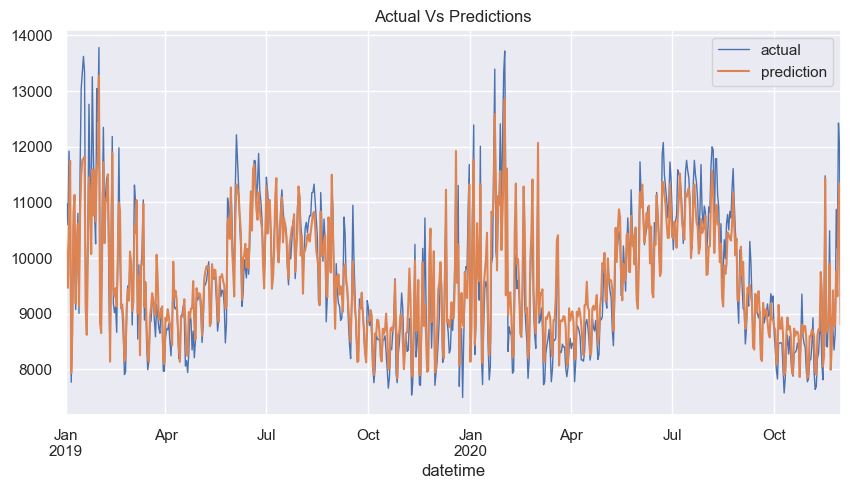

In [15]:
ax = y_max_val.plot(figsize=(10, 5), ms=1, lw=1, title='Actual Vs Predictions')
pd.DataFrame({'Predictions':reg_max.predict(X_val)}, index=y_max_val.index).plot(ax=ax)
plt.legend(['actual', 'prediction'])
plt.show()